# NEOPRENE notebooks

***

This notebook is part of a notebook collection available at the [NEOPRENE Project Site](https://github.com/IHCantabria/NEOPRENE) for illustration, reproducibility and reusability purposes. This notebook is licensed under the the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

## Calibrating and synthetic simulation of single-site Rainfall with the NSRPM.

In this script we calibrate the NSRPM (Neyman Scott Rectangular Pulse Model) using two rainfall series with different rainfall regimes: one with daily data located in the north of Spain, on a temperate climate (Cfb), and other with hourly data located in New Mexico (USA) on a semi-arid climate (BSh-BSk). The calibration parameters are used to simulate several decades of synthetic rainfall data which can be very useful for rainfall extreme analysis or disaggregation purposes, among other applications.

The script also contains:

1. a validation section where the observed series are compared with the simulated ones in terms of their statistics and exceedance probabilities. 

2. a disaggregation function to disaggreate daily to hourly rainfall data.

<font color='red'>Please, be advised that some of the processes may take up to 5 minutes in a modern computer.</font>

### Load packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from NEOPRENE.NSRP.HiperParams import Calibration as Calhps, Simulation as Simhps
from NEOPRENE.NSRP.Calibration import Calibration
from NEOPRENE.NSRP.Statistics import Statistics
from NEOPRENE.NSRP.Simulation import Simulation
from NEOPRENE.NSRP.Analysis import Analysis

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Example 1. Calibration and validation of daily data

### Loading daily rainfall data for daily data point

In [5]:
Serie_PD = pd.read_csv('auxiliary-materials/Point_Daily.csv', sep=";", decimal=".", index_col=0, parse_dates=True)
Serie_PD[Serie_PD.values<0] = np.nan
Input_Serie = pd.DataFrame(index=Serie_PD.index)
Input_Serie['Rain'] = Serie_PD.values

### Plotting daily data and seasonality

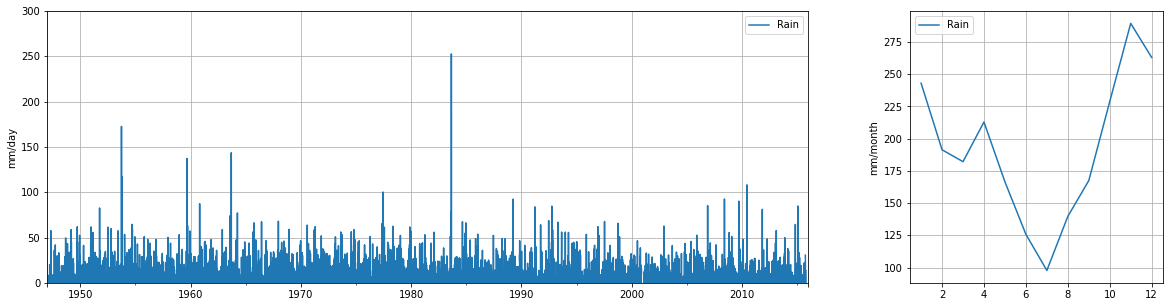

In [6]:
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(20, 5))

t1=str(Input_Serie.index.year[0])
t2=str(Input_Serie.index.year[-1])
Input_Serie.plot(xlim=(t1, t2),  ylim=(0, 300), ax = ax0)
ax0.grid(True)
ax0.set_ylabel('mm/day')

grouped_m = Input_Serie.groupby(lambda x: x.month)
Month_sum = grouped_m.sum()*24/(len(Input_Serie>=0)/30)
Month_sum.plot(ax = ax1)
ax1.grid(True)
ax1.set_ylabel('mm/month');

### Calibration

The calibration input file ([Input_Cal_PD.yml](https://github.com/IHCantabria/NEOPRENE/blob/main/notebooks/Input_Cal_PD.yml)) contains the hyperparameters to calibrate the model. This hyperparameters are loaded by the ```Calibration``` class within the ```NEOPRENE.NSRP.HiperParams``` module. In this notebook, the module is loaded as ```Calhps```.

Input rainfall statistics can be directly calculated by the software from a time series or can be introduced from a file with the statistics (both options are shown in the present notebook).

A description of the hyperparamters available in the calibration file ([Input_Cal_PD.yml](https://github.com/IHCantabria/NEOPRENE/blob/main/notebooks/Input_Cal_PD.yml)) can be found within the ```doc``` folder of the [project repository](https://github.com/IHCantabria/NEOPRENE).

In [7]:
# Reading hiperparamteres for the calibration
hiper_params_cal = Calhps('./Input_Cal_PD.yml')

The original time series statistics are computed first, as the model calibrates against those statistics. Once the statistics have been computed, the library does not need the complete time series anymore.

In [8]:
# Input statistics calculated from a Rainfall serie
statistics_model_1 = Statistics(hiper_params_cal, time_series = Input_Serie)

# Input statistics from file 
#statistics_model_2 = Statistics(hiper_params_cal, file = 'auxiliary-materials/statististics_PD.csv')

The hyperparameters are passed to the Calibration class which return a calibrator object. This object can be used as a function, that receives the statistics that need to be reproduced by the model. The object can also save the calibrated parameters to disk for later use.

In [9]:
CAL              = Calibration(hiper_params_cal) 
CAL1             = CAL(statistics_model_1, verbose=False)
#CAL2             = CAL(statistics_model_2, verbose=False)

os.makedirs('./POINT_DAILY/CAL1/',exist_ok=True)

CAL1.save_files('./POINT_DAILY/CAL1/')
#CAL2.save_files('./CAL2/')



################################################################################
Adjustment of parameters using the Particle Swarm Optimization (PSO)




In [10]:
CAL1.Fitted_parameters

,1,2,3,4,5,6,7,8,9,10,11,12
landa,0.128261,0.108203,0.144308,0.134790,0.163289,0.183130,0.089111,0.029312,0.040258,0.063826,0.135090,0.114446
ipsilon,14.121438,22.868196,7.943635,12.464418,6.212802,2.532914,7.539941,14.556630,37.899773,67.987757,16.117370,17.328537
eta,37.594041,58.873217,31.828964,38.449106,30.809707,17.895066,34.518502,15.583323,45.541292,95.053762,34.928537,37.217864
xi,0.012000,0.012000,0.012000,0.012000,0.012000,0.012000,0.012000,0.012000,0.012000,0.012000,0.012000,0.012000
betha,0.480000,0.480000,0.480000,0.810152,0.705880,0.801458,1.636777,1.115610,1.629725,1.016131,0.480000,0.480000


### Simulation

The input simulation file ([Input_Sim_PD.yml](https://github.com/IHCantabria/NEOPRENE/blob/main/notebooks/Input_Sim_PD.yml)) contains the hypermarametes for rainfall simulation.

A description of the hyperparamters available in the simulation file ([Input_Sim_PD.yml](https://github.com/IHCantabria/NEOPRENE/blob/main/notebooks/Input_Sim_PD.yml)) can be found within the ```doc``` folder of the [project repository](https://github.com/IHCantabria/NEOPRENE).

The first thing we do is to load the hyperparameters

In [11]:
# Reading hiperparamteres for the simulation
hiper_params_sim = Simhps('./Input_Sim_PD.yml')

And those hyperparameters are then used to configure the Simulation class, which return a Simulation object that is used in a very similar way to the Calibration object.

In [12]:
SIM              = Simulation(hiper_params_sim) 

# Input parameters from the model
SIM1             = SIM(params_cal = CAL1)

# Input parameters from a dataframe

os.makedirs('./POINT_DAILY/SIM1/',exist_ok=True)
SIM1.save_files('./POINT_DAILY/SIM1/')

#SIM2             = SIM(params_cal = './CAL2/Calibrated_parameters.csv')
#SIM2.save_files('./SIM1/')



################################################################################
Synthetic simulation


Total cumulative rainfall - Analytical estimation =        95269.78
Total cumulative rainfall -             Simulated =        94859.16


## Analysis of results
In this section, an analysis of the results is made. 

In [13]:
Analysis_results = Analysis(CAL1,SIM1)

### Verification

The curve of exceedence probabilities is shown to evaluate the quality of the fit of the simulations and the observations

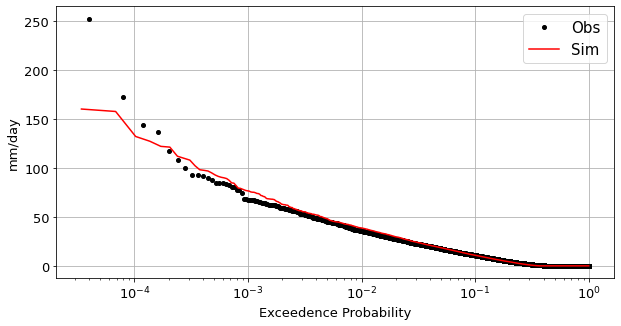

In [14]:
# Comparing exceedence Probability betwen Observed and Simulated series
Analysis_results.exceedence_probability_fig(Input_Serie, SIM1.Daily_Simulation)

### Validation

Another set of verification plots is generated where the value of different observed statistics (dashed line) is compared against the fitted statistics (blue squares), that is, the best values of the statistic that the optimal parameters were able to reproduce, and against the simulated statistics (red triangles), the values of the statistics that were obtained when simulating synthetic time series with the calibrated parameters.

The model correctly reproduces those parameters for which it is calibrated. Those parameters that do not participate in the calibration procedure may exhibit a more erratic behavior, thus the differences between the calibrated and simulated values of the statistics.

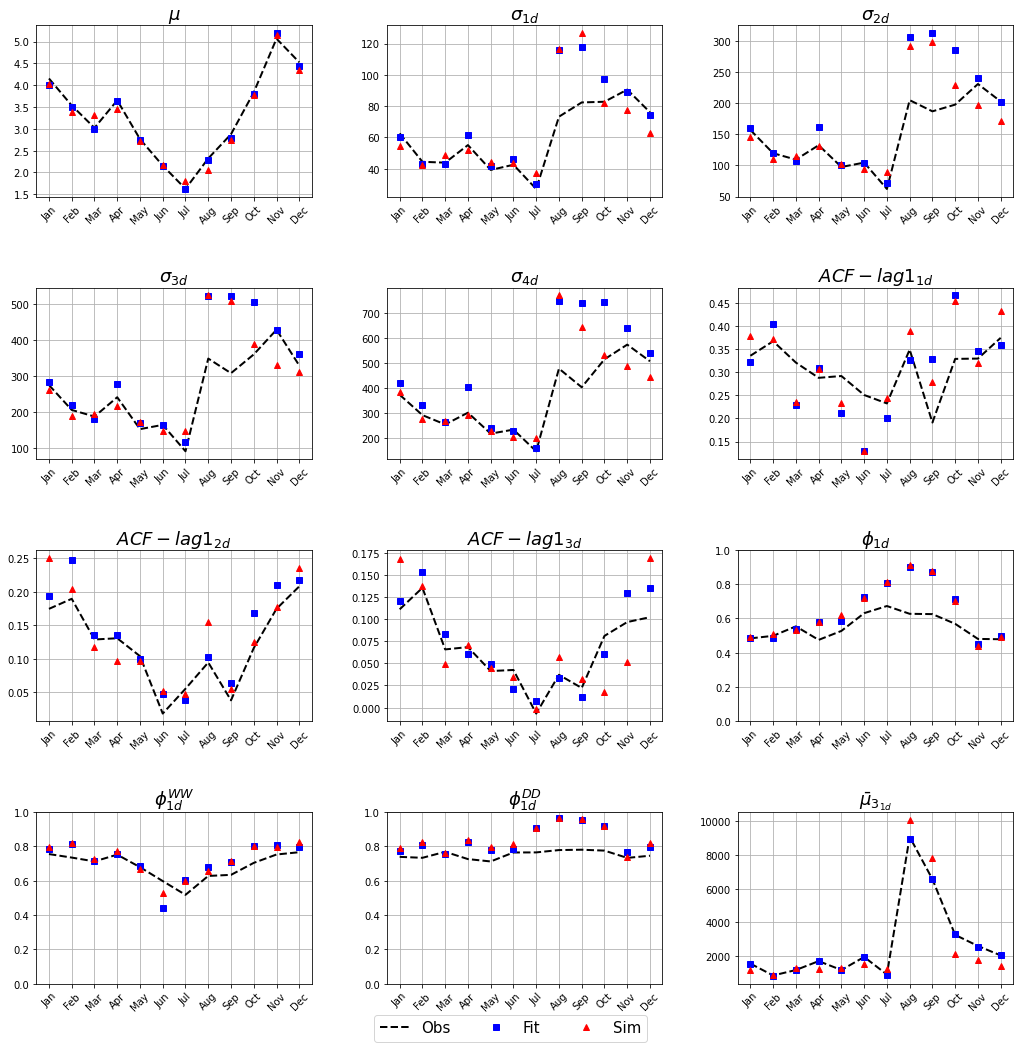

In [15]:
# Comparing the values of the statistcs (observed, fitted and simulated).
Analysis_results.compare_statistics_fig()

# Example 2. Disaggregation of daily data to hourly data

Disaggregation process might take some minutes to dissagregate several decades of data. Here we select only 5 year as an example

In [16]:
# Period selected from the input (onserved) serie
year1 = 2000; year2 = 2005
x_series = Input_Serie[(Input_Serie.index.year >= year1) & (Input_Serie.index.year < year2)]

In [17]:
# Defining hourly synthetic serie
y_series = SIM1.Hourly_Simulation.copy()

In [18]:
# Daily-to-hourly disaggregation
Analysis_results.disaggregate_rainfall(x_series, y_series)
hourly_disaggregation = Analysis_results.hourly_disaggregation

In [19]:
# Resampling hourly disaggregated serie to daily one
daily_disaggregation = hourly_disaggregation.resample('D').agg(pd.Series.sum, min_count=1)
# Calculating statistics from the disaggregated daily resample serie and for the period selected from the Input serie
statistics_model_3 = Statistics(hiper_params_cal, time_series = x_series)
statistics_disaggregated = Statistics(hiper_params_cal, time_series = daily_disaggregation)

In [20]:
# Comparing daily observed statiscis with dialy dissagregated ones

statistics_model_3.statististics_dataframe.compare(statistics_disaggregated.statististics_dataframe)

1                       2                       3  \
                    self       other        self       other        self   
mean            3.507258    2.818855    2.702817    2.706876    2.089677   
var_1          41.278254   34.912705   26.169006   26.226568   24.566345   
var_2         114.271697   95.125295   69.624087   69.876936   64.404748   
var_3         191.495883  176.150414  114.143424  114.576551   86.517336   
var_4         244.190762  232.274265  149.908573  150.405572  153.306287   
autocorr_1_1    0.404013    0.434797    0.431723    0.432804    0.262477   
autocorr_2_1    0.138685    0.184189    0.203420    0.209648    0.113781   
autocorr_3_1    0.058755    0.108890    0.059803    0.059511   -0.012867   
fih_1           0.516129    0.610390         NaN         NaN    0.600000   
fiWW_1          0.750000    0.750000    0.632353    0.676471    0.629032   
fiDD_1          0.765625    0.840426    0.662162    0.702703    0.752688   
M3_1          632.177191  562.927585  331.922783  333.031752  417.915617   

                                   4                       5              ...  \
                   other        self       other        self       other  ...   
mean            2.082907    2.910000    2.911553    2.270323    2.265447  ...   
var_1          24.443562   31.787167   31.832094   25.825700   25.762380  ...   
var_2          63.631120   78.969857   79.630898   76.422623   76.028223  ...   
var_3          85.674728  108.986697  109.967396  129.231451  128.852506  ...   
var_4         151.843907  186.852243  189.326337  149.577874  149.075207  ...   
autocorr_1_1    0.257576    0.291502    0.299158    0.440110    0.437610  ...   
autocorr_2_1    0.113236   -0.006437   -0.004812    0.231821    0.230195  ...   
autocorr_3_1   -0.013664   -0.062024   -0.062702   -0.025212   -0.027327  ...   
fih_1           0.593548    0.433333    0.460000    0.587097    0.593548  ...   
fiWW_1          0.682540    0.776471    0.716049    0.609375    0.587302  ...   
fiDD_1          0.782609    0.707692    0.666667    0.725275    0.717391  ...   
M3_1          414.324748  552.230324  551.772140  409.973966  406.947478  ...   

                       8                       9                      10  \
                    self       other        self       other        self   
mean            1.465161    1.466379    1.595333    1.597912    3.713548   
var_1          14.645625   14.583702   24.285778   24.310812   48.780268   
var_2          39.471373   39.504738   48.443716   48.847753  107.637725   
var_3          54.320972   54.562973   76.135189   76.762259  185.415352   
var_4          96.148759   96.348502   82.866222   83.592919  236.532834   
autocorr_1_1    0.249681    0.254862    0.012462    0.016772    0.209096   
autocorr_2_1    0.245928    0.248163   -0.024377   -0.024432    0.065464   
autocorr_3_1    0.181772    0.183052   -0.022858   -0.022619   -0.021027   
fih_1           0.638710    0.651613         NaN         NaN    0.496774   
fiWW_1          0.696429    0.648148    0.551020    0.530612    0.705128   
fiDD_1          0.828283    0.811881    0.782178    0.772277    0.701299   
M3_1          242.032888  238.415427  648.894994  651.100045  841.705477   

                                   11                        12               
                   other         self        other         self        other  
mean            3.702906     4.966187     4.620827     5.054032     4.039612  
var_1          48.457665    64.706555    62.814861   101.595064    86.218651  
var_2         106.890993   147.754517   145.718206   302.384470   250.218530  
var_3         182.368409   195.728830   198.266629   516.092908   426.134332  
var_4         233.938530   319.808040   321.499848   872.480826   530.112256  
autocorr_1_1    0.208644     0.136999     0.152074     0.583768     0.607771  
autocorr_2_1    0.061402    -0.086107    -0.064657     0.424919     0.443233  
autocorr_3_1   -0.021844    -0.055104    -0.047

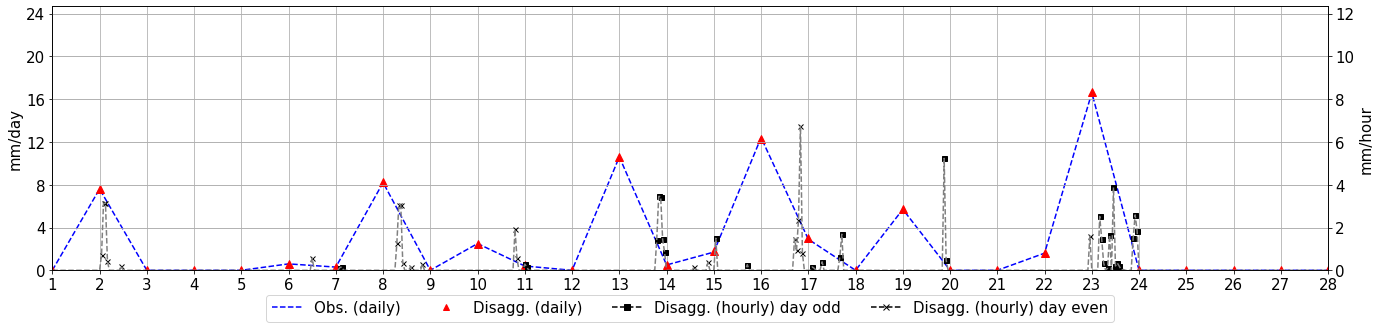

In [21]:
Analysis_results.figure_disaggregation_fig(hourly_disaggregation,daily_disaggregation,x_series,year1,year1)

### Save Figures
To save the figures in png format we execute the following line

In [22]:
Analysis_results.save_figures('./POINT_DAILY/Figures/')

# Example 3. Calibration and Simulation of hourly data

### Loading hourly rainfall data for hourly data point

In [23]:
Serie_PH=pd.read_csv('auxiliary-materials/Point_Hourly.csv', sep=",", decimal=".", index_col=0, parse_dates = True)
Serie_PH[Serie_PH.values<0]=np.nan
Input_Serie=pd.DataFrame(index=Serie_PH.index)
Input_Serie['Rain']=Serie_PH.values

### Plotting hourly data and seasonality

Text(0, 0.5, 'mm/month')

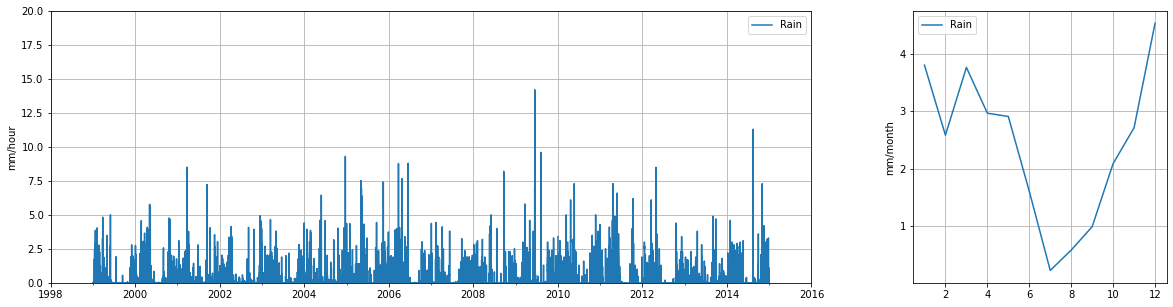

In [24]:
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(20, 5))

t1=str(Input_Serie.index.year[0]); t2=str(Input_Serie.index.year[-1])
Input_Serie.plot(xlim=(t1, t2),  ylim=(0, 20), ax = ax0)
ax0.grid(True)
ax0.set_ylabel('mm/hour')

grouped_m = Input_Serie.groupby(lambda x: x.month)
Month_sum=grouped_m.sum()*24/(len(Input_Serie>=0)/30)
Month_sum.plot(ax = ax1)
ax1.grid(True)
ax1.set_ylabel('mm/month')

### Calibration

In [25]:
hiper_params_cal = Calhps('./Input_Cal_PH.yml')
statistics_model_1 = Statistics(hiper_params_cal, time_series = Input_Serie)

In [26]:
CAL              = Calibration(hiper_params_cal) 
CAL1             = CAL(statistics_model_1, verbose=False)

os.makedirs('./POINT_HOURLY/CAL1/', exist_ok=True)

CAL1.save_files('./POINT_HOURLY/CAL1/')



################################################################################
Adjustment of parameters using the Particle Swarm Optimization (PSO)




### Simulation

In [27]:
hiper_params_sim = Simhps('./Input_Sim_PH.yml')

SIM              = Simulation(hiper_params_sim) 
SIM1             = SIM(params_cal = CAL1)
#SIM2             = SIM(params_cal = './CAL2/Calibrated_parameters.csv')



################################################################################
Synthetic simulation


Total cumulative rainfall - Analytical estimation - Storm 1 =         1518.69
Total cumulative rainfall - Analytical estimation - Storm 2 =          706.22
Total cumulative rainfall - Analytical estimation =         2224.91
Total cumulative rainfall -             Simulated =         1988.38


In [28]:
os.makedirs('./POINT_HOURLY/SIM1/',exist_ok=True)
SIM1.save_files('./POINT_HOURLY/SIM1/')

## Analysis of results
In this section, an analysis of the results is made. 

In [29]:
Analysis_results = Analysis(CAL1,SIM1)

### Validation

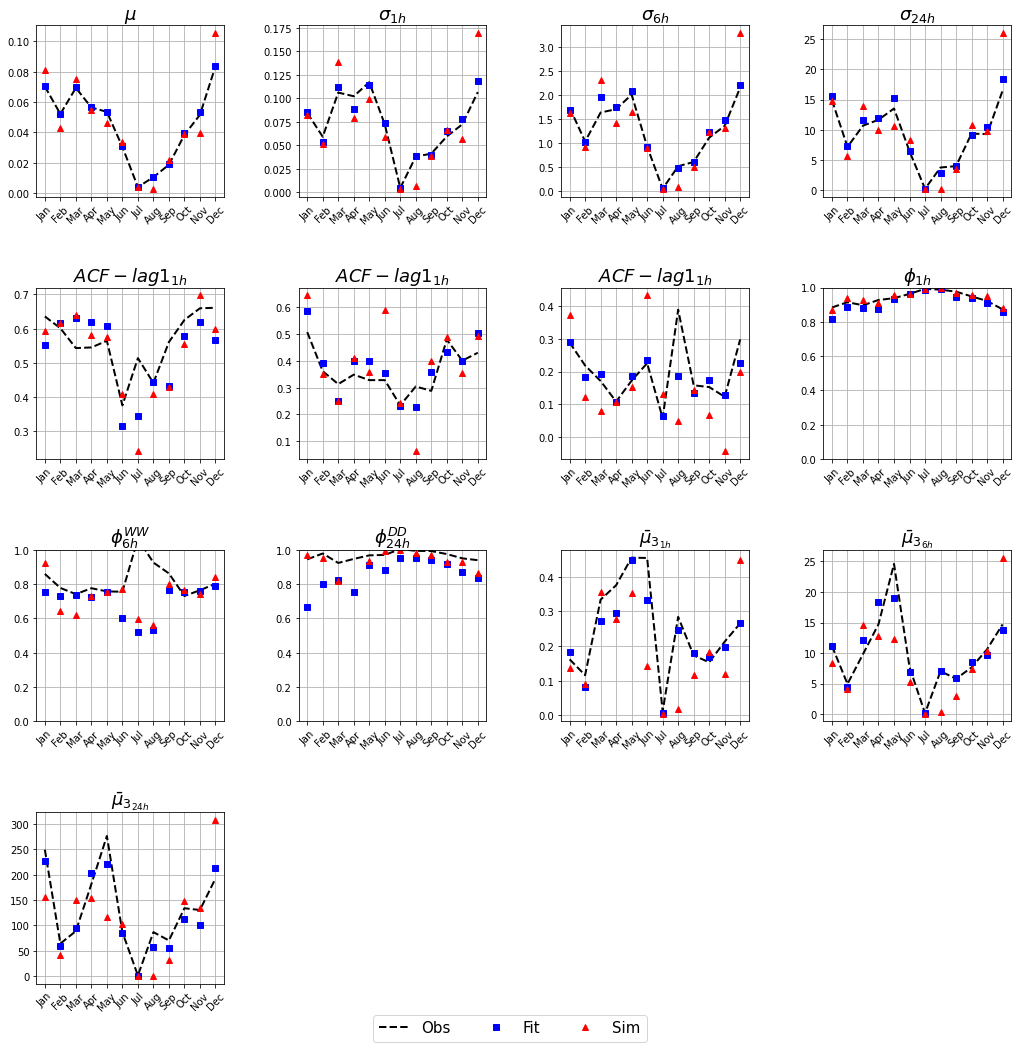

In [30]:
# Comparing the values of the statistcs (observed, fitted and simulated).
Analysis_results.compare_statistics_fig()

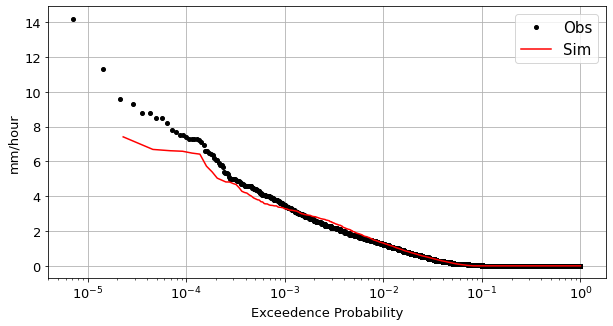

In [31]:
# Comparing exceedence Probability betwen Observed and Simulated series
Analysis_results.exceedence_probability_fig(Input_Serie, SIM1.Hourly_Simulation)

### Save Figures
To save the figures in png format we execute the following line

In [32]:
Analysis_results.save_figures('./POINT_HOURLY/Figures/')

# Session info

In [33]:
!conda list

# packages in environment at /Users/salvadornavasfernandez/opt/anaconda3/envs/NEOPRENE:
#
# Name                    Version                   Build  Channel
altgraph                  0.17.2             pyhd8ed1ab_0    conda-forge
anyio                     3.4.0            py39h6e9494a_0    conda-forge
appnope                   0.1.2           py39hecd8cb5_1001  
argon2-cffi               20.1.0           py39h9ed2024_1  
async_generator           1.10               pyhd3eb1b0_0  
attrs                     21.2.0             pyhd3eb1b0_0  
auto-py-to-exe            2.17.0                   pypi_0    pypi
babel                     2.9.1              pyh44b312d_0    conda-forge
backcall                  0.2.0              pyhd3eb1b0_0  
blas                      1.0                         mkl  
bleach                    4.0.0              pyhd3eb1b0_0  
bottle                    0.12.19                  pypi_0    pypi
bottle-websocket          0.2.9                    pypi_0    pypi
bott